The Idea of this notebook is to be able to generate an input file for the DART obs_seq programs 

Options include:
 
Perfect track
    - grid resolution
    - "noisy" resolution
    - ITD
    - real lat/lon with self-calculated freeboard vs real lat/lon with available thickness and appropriate error 

Real track
    - raw track 
    - segment weighted smoothing (from Alek)
    - ITD
    
    
Overlap: ITD 

Question: can freeboard be negotiated into a distribution based on the ITD

In [1]:
##TO DOS

# Fix time issue in write netcdf function
# Add in QC variable to dataset written to netcdf that will eliminate NaN values (could also just replace 
    #those with very large numbers, will be discarded in the conversion script in DART anyway)
# Add in plotting utils in the functions as sanity checks for what's going on with the track selection and the noise


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import path
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import scipy.interpolate as interp

In [4]:
file =  '/glade/scratch/mollyw/free30/run/free30.cice_0024.h.2019-04-15.nc'

In [11]:
# write_Obs_input(file, 'ideal_osse','high','freeboard','perfect_freeboard_noisy')
write_Obs_input(file, 'ideal_osse','low','freeboard','perfect_freeboard_ni200_sic')
# write_Obs_input(file, 'ideal_osse','high','thickness','perfect_thickness_noisy')
# write_Obs_input(file, 'ideal_osse','low','thickness','perfect_thickness_circle')

In [10]:
def write_Obs_input(file, option, resolution, variable, file_out_name): 
    ds  = xr.open_dataset(file)
    
    if option == 'ideal_osse': 
        gridline = 200
        ds_track = ds.sel(ni = gridline)#.sel(ni = slice(75,250))
#         ds_track = ds.sel(ni = gridline).sel(nj = slice(340,-1))
        
        # get desired quantity
        if variable == 'freeboard':
            ds_var = get_freeboard(ds_track)
            error = 0.01 # 1cm error
        elif variable == 'thickness':
            ds_var = get_thickness(ds_track)
            error = 0.1 # 10cm error 
        
        # add random noise 
        ds_var = add_draw(ds_var, error)
        
        # if desired, make a denser observational set 
        if resolution == "high":
            step = 0.001
            ds_var = make_noisy(ds_var, step, error)
        else:
            ds_var = ds_var
        
        # write netcdf file 
        file_out = write_netcdf_file(ds_var, variable, error, file_out_name)

        
    elif option == 'obs_osse':
        print("NotYetImplemented")
        # pull lat lon from default IS2 track; consider eventually building out functionality to get different locations 
        file_out = write_input_file(lat, lon, vals, variable, error)
    elif option == 'real':
        print("NotYetImplemented")
        # do everything from the IS2 track 

    
    return file_out 
        

#### functions for "ideal_osse"

In [7]:
def get_freeboard(ds_track):
     
    # set up constants (same values as DART)
    ice_dens   =  917.0
    snow_dens  =  330.0
    water_dens = 1026.0
    
    # isolate aice, vsno, vice by category 
    vice_volume = ds_track.vicen
    snow_volume = ds_track.vsnon
    aice_volume = ds_track.aicen.sum(dim = 'nc')
    
    # calculate agregate freeboard and concentration
    for i in range(1,5):
        #(from DART code obs_def_cice_mod.f90)
        
        fb_volume =+ (vice_volume.sel(nc=i)*(1 - ice_dens/water_dens) - snow_volume.sel(nc=i)*snow_dens/water_dens)#/aice_volume.sel(nc =i).max()
    
    fb_agreg = fb_volume.where(aice_volume > 1e-6)/aice_volume.where(aice_volume > 1e-6)
    return fb_agreg

def get_thickness(ds_track):
     
    vice_volume = ds_track.vicen   
    hi_agreg = vice_volume.sum(dim = 'nc')
    aice_volume = ds_track.aicen.sum(dim = 'nc')
    hi_agreg = hi_agreg.where(aice_volume > 1e-6)
    
    return hi_agreg

    
def get_itd(ds_track):
    
    return "NotYetImplemented"

def add_draw(variable, error):
    
    # test plot
    # variable.plot()
    
    noise = np.random.normal(0,error,np.shape(variable)[1])
    
    # ensure positivity 
    variable = xr.ufuncs.fabs(variable + noise)
    
    # test plot 
    # variable.plot()
    
    return variable

def make_dense(variable, step, error):
    # MAKE SURE THAT THE RANDOM NOISE has the same error covariance as the observations
    
    xx = len(variable.TLAT.values) # determine how many grid points the track intersects
    
    # interpolate to 1/10 of that grid
    variable_fine = variable.interp(nj=list(np.arange(0,xx,step)), method='linear', assume_sorted=False, kwargs={"fill_value": "extrapolate"})

    # make noise distribution 
    noise = np.random.normal(0,error,np.shape(variable_fine)[1])
    
    # multiply by the noise distribution
    variable_noisy = variable_fine + noise
    variable_noisy = xr.ufuncs.fabs(variable_noisy)
    print(variable_noisy)
    variable_noisy.plot(x = 'TLON')
    
    return variable_noisy

def fix_time(ds):
    mytime = ds['time'].data
    for time in range(mytime.size):
        mytime[time] = mytime[time].replace(day=mytime[time].day-1)
    ds = ds.assign_coords(time=mytime)
    
    return ds
    

def write_netcdf_file(ds_var, variable, error, file_out_name):
 
    if variable == "freeboard":
        variable_dict = dict(freeboard=(["time","nj"], ds_var))
    elif variable == "thickness":
        variable_dict = dict(thickness=(["time","nj"], ds_var))
    
    dset = xr.Dataset(
        data_vars= variable_dict,
        coords=dict(
            lon=(["nj"], ds_var.TLON),
            lat=(["nj"], ds_var.TLAT),
            time=ds_var.time),
        attrs=dict(description= variable+" track, osse"))
    
    dset = dset.fillna(-888888)
    dset = fix_time(dset)
    
    nc_file = dset.to_netcdf('/glade/work/mollyw/DART/observations/obs_converters/cice/data/' + file_out_name + '.nc') #'/glade/work/mollyw/DART/observations/obs_converters/cice/data/' +
    
    return nc_file
    
    
def write_input_file(lat, lon, vals, variable, error):
    # add a check system to make sure that any non-physical values get read as bad obs
    
    if variable == "freeboard": 
        code = 11
    elif variable == "thickness":
        code = 1001
        
    my_file = open('input_file.txt','w')
    initalize = [str(len(lat) + 10) + "\n", "0\n","0\n","0\n"]
    my_file.writelines(initalize)
    
    for x in np.arange(0,len(lat)):
        if x == len(lat) - 1:
            my_file.writelines(str(code)+'\n -1\n 0\n' + "%.4f" % lon[x] + '\n' + "%.4f" % lat[x] + '\n' + '2019 4 15 0 0 \n' + str(error) + '\n -1 \n')
        else:
            my_file.writelines(str(code)+'\n -1\n 0\n' + "%.4f" % lon[x] + '\n' + "%.4f" % lat[x] + '\n' + '2019 4 15 0 0 \n' + str(error) + '\n 0 \n')
    my_file.close()
    
    return 'File written to input_file.txt!'


Just a pretty grid picture for understanding

38


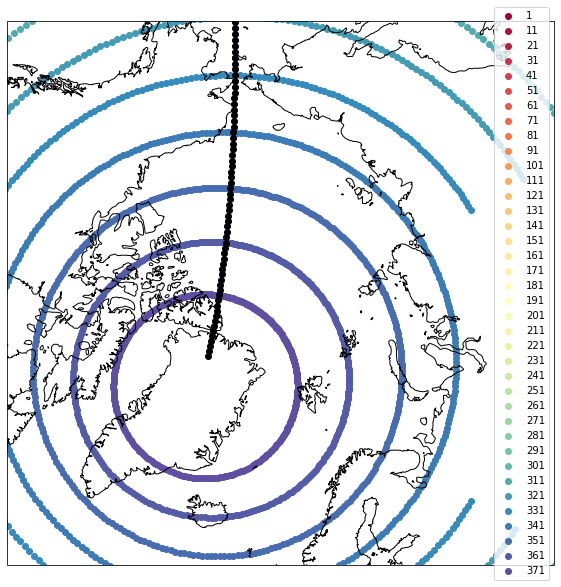

In [9]:
ds  = xr.open_dataset(file)
plt.figure(figsize=(10,10))
# Make a new projection "NorthPolarStereo"
# ccrs.PlateCarree
ax = plt.axes(projection=ccrs.NorthPolarStereo()) #true_scale_latitude=70
k=10
l = int(380/k)
col = plt.cm.Spectral(np.linspace(0,1,l))
col2 = plt.cm.inferno(np.linspace(0,1,l))
count = 0
for i in np.arange(1,380,k):
    ds_track = ds.sel(nj = i)
    plt.scatter(ds_track.TLON, ds_track.TLAT, color = col[count], transform=ccrs.PlateCarree(), label = str(i))
    count += 1 
    
print(count)
    
count = 0
j = 200 # np.arange(1,320,k):
ds_track2 = ds.sel(ni = j)#.sel(ni = slice(75,250))
# ds_track2 = make_noisy(ds_track2.hi,0.1,0.15)
plt.scatter(ds_track2.TLON, ds_track2.TLAT, color = col2[count], transform=ccrs.PlateCarree())
count += 1
plt.legend()
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())   

#### DEV for "obs_osse"

#### DEV for "real"